<div align=right><i>Peter Norvig<br>2 June 2019</i></div>

# Tracking Trump: Electoral Votes Edition

[538](https://projects.fivethirtyeight.com/trump-approval-ratings/) shows presidential approval ratings (currently about 42% (±4) approval and 53% (±4) disapproval). Do approval ratings predict election results? There are three big caveats:

1. These are  approval polls, not votes. 

2. This is today, not election day 2020. 

3. These are popular votes, not electoral votes. 

We can't be conclusive about the first two points, but this notebook can take the state-by-state, month-by-month approval data from Morning Consult's
[Tracking Trump](https://morningconsult.com/tracking-trump/) web page and compute electoral votes, under the assumption that Trump wins the electoral votes of states he has positive net approval (and for the purposes of computation we'll assign half the electoral votes for states where approval exactly equals disapproval).


# TL;DR for policy wonks

As of 1 May 2019, Trump would expect  **193 electoral votes** under these assumptions (recall that you need **270** to win). He's been below 270 every month for the last two years, and that remains true even if you factor in an across-the-board 3% swing in his favor (which was the swing above polls that he experienced in 2016).


# The details for data science nerds

We don't know who else will be on the ballot and what their approval levels will be, we don't know if there is systematic bias in the polling data, we don't know how many people will vote for a candidate they disapprove of or against a candidate they approve of, and we don't know who will decline to vote.
I have five ways of understanding the fluidity of the situation:

- **Undecided**: If many voters are undecided, the net approval could change a lot. So I track the number of states for which at least 5% of voters are undecided. At the inauguration in 2017, all 51 states (including DC) had at least 5% undecided; now there is only one such state (Alaska). Overall 4% of voters are undecided. Most people have made up their mind.

- **Variance**: How much are voters changing their minds from month to month in each state?  I track the standard deviation, 𝝈, of the net approval for each state over the last 12 months.

- **Movement**: What's the most a state's net approval could be expected to move, due to random fluctuations (that is, assuming there is no big event that changes people's minds)? I define the maximum expected  **movement** of a state as 1/5 of the undecided voters (i.e. assume the undecided voters broke 60/40 one way or the other) plus 2 standard deviations in the net approval over the last 12 months. 

- **Swing state**: I define a swing state as one whose maximum expected movement is greater than the absolute value of the net approval. There are 15 such states now. (My definition correlates well with the standard wisdom on swing states, but with a few surprises, such as North Dakota, where Trump is currently only +1% net approval. My model does not count Pennsylvania, Michigan, and Wisconsin as swing states, because Trump is currently -7%, -12% and -13% respectively, and expected movement is low at 3% to 5%.) If Trump won all the swing states he would get **253** electoral votes, and if he lost them all, **76** electoral votes.

- **Margin**: Suppose a future event swings voters in one direction or another uniformly, across the board in all states. How much of a swing would be necessary to change the election outcome? We call that the **margin**. Today **Trump's margin is 7%:** if he got 7% more votes in all states he would be over 270 electoral votes. (This could come, for example, by convincing undecided voters to break for him at a 2% to 1% ratio, and then convincing 3% of disapproving voters to switch to approving.)

# Data and Code

First fetch the [Tracking Trump](https://morningconsult.com/tracking-trump/) web page and cache it locally: 

In [1]:
! curl -o evs.html https://morningconsult.com/tracking-trump/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  116k    0  116k    0     0   193k      0 --:--:-- --:--:-- --:--:--  193k


Now define the code. Note that `data` contains the [electoral votes by state](https://www.britannica.com/topic/United-States-Electoral-College-Votes-by-State-1787124) and the [partisan lean by state](https://github.com/fivethirtyeight/data/tree/master/partisan-lean) (how much more Republican (plus) or Democratic (minus) leaning the state is compared to the country as a whole, across multiple recent elections), and `net_usa` has the [country-wide net presidential approval](https://projects.fivethirtyeight.com/trump-approval-ratings/).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import ast
from collections import namedtuple
from IPython.display import display, Markdown
from statistics import stdev

data = { # From https://github.com/fivethirtyeight/data/tree/master/partisan+lean 
         # a dict of {"state name": (electoral_votes, partisan_lean)}
  "Alabama": (9, +27),         "Alaska": (3, +15),          "Arizona": (11, +9),         
  "Arkansas": (6, +24),        "California": (55, -24),     "Colorado": (9, -1),          
  "Connecticut": (7, -11),     "Delaware": (3, -14),        "District of Columbia": (3, -43),
  "Florida": (29, +5),         "Georgia": (16, +12),        "Hawaii": (4, -36),           
  "Idaho": (4, +35),           "Illinois": (20, -13),       "Indiana": (11, +18),        
  "Iowa": (6, +6),             "Kansas": (6, +23),          "Kentucky": (8, +23),        
  "Louisiana": (8, +17),       "Maine": (4, -5),            "Maryland": (10, -23),        
  "Massachusetts": (11, -29),  "Michigan": (16, -1),        "Minnesota": (10, -2),        
  "Mississippi": (6, +15),     "Missouri": (10, +19),       "Montana": (3, +18),         
  "Nebraska": (5, +24),        "Nevada": (6, +1),           "New Hampshire": (4, +2),    
  "New Jersey": (14, -13),     "New Mexico": (5, -7),       "New York": (29, -22),        
  "North Carolina": (15, +5),  "North Dakota": (3, +33),    "Ohio": (18, +7),            
  "Oklahoma": (7, +34),        "Oregon": (7, -9),           "Pennsylvania": (20, +1),    
  "Rhode Island": (4, -26),    "South Carolina": (9, +17),  "South Dakota": (3, +31),    
  "Tennessee": (11, +28),      "Texas": (38, +17),          "Utah": (6, +31),            
  "Vermont": (3, -24),         "Virginia": (13, 0),         "Washington": (12, -12),      
  "West Virginia": (5, +30),   "Wisconsin": (10, +1),       "Wyoming": (3, +47)}

net_usa = {        # From https://projects.fivethirtyeight.com/trump-approval-ratings/
 '1-Jan-17': +10,  # a dict of {date: country-wide-net-approval}
 '1-Feb-17':   0, '1-Mar-17':  -6, '1-Apr-17': -13, '1-May-17': -11,
 '1-Jun-17': -16, '1-Jul-17': -15, '1-Aug-17': -19, '1-Sep-17': -20,
 '1-Oct-17': -17, '1-Nov-17': -19, '1-Dec-17': -18, '1-Jan-18': -18,
 '1-Feb-18': -15, '1-Mar-18': -14, '1-Apr-18': -13, '1-May-18': -12,
 '1-Jun-18': -11, '1-Jul-18': -10, '1-Aug-18': -12, '1-Sep-18': -14,
 '1-Oct-18': -11, '1-Nov-18': -11, '1-Dec-18': -10, '1-Jan-19': -12,
 '1-Feb-19': -16, '1-Mar-19': -11, '1-Apr-19': -11, '1-May-19': -12}

State = namedtuple('State', 'name, ev, lean, approvals, disapprovals')
State.__doc__ = '''A State has a name, the number of electoral votes (.ev),
the partisan lean (.lean) and two dicts of {date: percent}: .approvals and .disapprovals'''

def parse_page(filename='evs.html', data=data):
    "Read data from the file and return (list of dates, list of `State`s, last date)."
    # File format: Date headers, then [state, approval, disapproval ...]
    # [["Demographic","1-Jan-17","","1-Feb-17","", ... "1-Apr-19",""],
    #  ["Alabama","62","26","65","29", ... "61","35"], ... ] =>
    # State("Alabama", 9, approvals={"1-Jan-17": 62, ...}, disapprovals={"1-Jan-17": 26, ...}), ...
    text   = re.findall(r'\[\[.*?\]\]', open(filename).read())[0]
    table  = ast.literal_eval(text)
    dates  = table[0][1::2]
    states = [State(name, *data[name],
                    approvals=dict(zip(dates, map(int, numbers[0::2]))),
                    disapprovals=dict(zip(dates, map(int, numbers[1::2]))))
              for (name, *numbers) in table[1:]]
    return dates, states, dates[-1]

dates, states, now = parse_page()

assert len(states) == 51 and sum(s.ev for s in states) == 538

def EV(states, date=now, swing=0):
    "Total electoral votes with net positive approval (plus half the votes for net zero)."
    return sum(s.ev * (1/2 if net(s, date) + swing == 0 else int(net(s, date) + swing > 0))
               for s in states)

def margin(states, date=now):
    "What's the least swing that would lead to a majority?"
    return next(swing for swing in range(-50, 50) if EV(states, date, swing) >= 270)

def net(state, date=now):         return state.approvals[date] - state.disapprovals[date]
def undecided(state, date=now):   return 100 - state.approvals[date] - state.disapprovals[date]
def movement(state, date=now):    return undecided(state, date) / 5 + 2 * 𝝈(state)
def 𝝈(state, recent=dates[-12:]): return stdev(net(state, d) for d in recent)
def is_swing(state):              return abs(net(state)) < movement(state)

def md(lines): display(Markdown('\n'.join(lines)))

# Current expected electoral votes, with various swings

In [3]:
EV(states)

193.0

In [4]:
margin(states)

7

In [5]:
{swing: EV(states, now, swing)
        for swing in range(10)}

{0: 193.0,
 1: 209,
 2: 209,
 3: 209,
 4: 225.5,
 5: 242,
 6: 254.0,
 7: 276.0,
 8: 286,
 9: 288.0}

We see that:
- Trump is currently leading in states with only 193 electoral votes; 
- The margin is 7% (if he got 7% more popular in every state, he would win a narrow 276 to 262 vote victory).
- Swings from 0 to 9% produce electoral vote totals from 193 to 288.

# Electoral votes by month

The following plot shows, for each month in office, the expected number of electoral votes (based on net approval) with error bars indicating a 3% swing in either direction (Why 3%? That was the [average error](https://fivethirtyeight.com/features/the-polls-are-all-right/) in national presidential polls in 2016: Clinton was predicted by polls to win the popular vote by 6% but actually only won by 3%.) Trump hasn't been above 270 since 4 months into his term, and even with the 3% swing, since 6 months in.

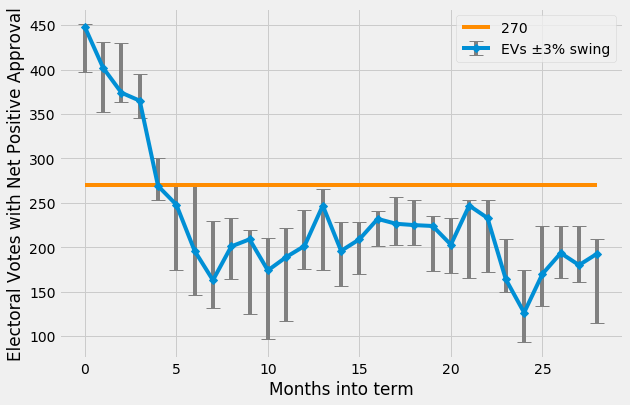

In [6]:
def labels(xlab, ylab): plt.xlabel(xlab); plt.ylabel(ylab); plt.grid(True); plt.legend()
    
plt.rcParams["figure.figsize"] = [9, 6]
plt.style.use('fivethirtyeight')
    
def plot1(states, dates, swing=3):
    N = len(dates)
    err = [[EV(states, date) - EV(states, date, -swing) for date in dates],
           [EV(states, date, swing) - EV(states, date) for date in dates]]
    plt.errorbar(range(N), [EV(states, date) for date in dates], fmt='D-',
                 yerr=err, ecolor='grey', capsize=7, label='EVs ±3% swing')
    plt.plot(range(N), [270] * N, color='darkorange', label="270")
    labels('Months into term', 'Electoral Votes with Net Positive Approval')
    
plot1(states, dates)

# Margin and country-wide net approval by month

The next plot gives the swing margin needed to reach 270 for each month, along with the country-wide net approval. Trump has been in negative territory on all metrics since his fourth month in office. We see that the state-by-state margin roughly correlates with the country-wide net approval, but not exactly.

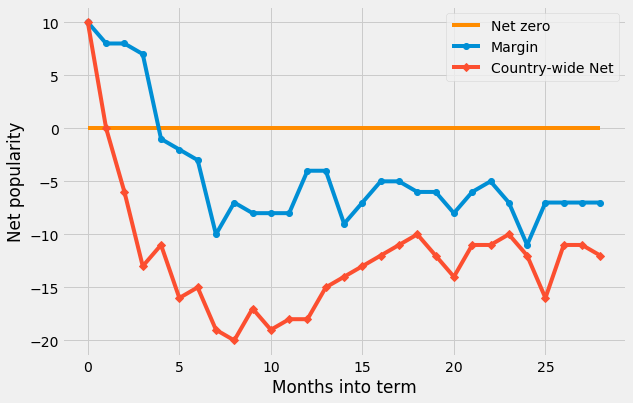

In [7]:
def plot2(states, dates):
    N = len(dates)
    plt.plot(range(N), [0] * N, label='Net zero', color='darkorange')
    plt.plot(range(N), [-margin(states, date) for date in dates], 'o-', label='Margin')
    plt.plot(range(N), [net_usa[date] for date in dates], 'D-', label='Country-wide Net')
    labels('Months into term', 'Net popularity')
    
plot2(states, dates)

# Month-by-month summary table

For each month, we show the expected electoral vote total (**EVs**), the swing margin needed to get to 270 (**Margin**), the overall (popular vote) net approval across the whole country (**Country**), and then the total percentage of undecided voters and in parentheses the number of states with at least 5% undecided.
Note that the country-wide vote is not all that correlated with the state-by-state margin: recently the state-by-state margin has held at 7% while the country-wide net approval has ranged from -10% to -16%, and when the state-by-state margin jumped to 11%, the country-wide measure stayed right in the middle at 12%.

In [8]:
def header(head): return head + '\n' + '-'.join('|' * head.count('|'))

def monthly(states, dates=reversed(dates)):
    yield header('|Month|EVs|Margin|Country|Undecided|')
    for date in dates:
        month = date.replace('1-', '').replace('-', ' 20')
        yield (f'|{month}|{int(EV(states, date))}|{margin(states, date)}%|{net_usa[date]}%'
               f'|{sum(s.ev * undecided(s, date) for s in states) / 538:.0f}% '
               f'({sum(undecided(s, date) > 5 for s in states)})|')
        
md(monthly(states))

|Month|EVs|Margin|Country|Undecided|
|-|-|-|-|-|
|May 2019|193|7%|-12%|4% (1)|
|Apr 2019|180|7%|-11%|4% (0)|
|Mar 2019|193|7%|-11%|4% (2)|
|Feb 2019|170|7%|-16%|4% (0)|
|Jan 2019|126|11%|-12%|4% (0)|
|Dec 2018|164|7%|-10%|5% (3)|
|Nov 2018|233|5%|-11%|4% (1)|
|Oct 2018|247|6%|-11%|4% (3)|
|Sep 2018|203|8%|-14%|4% (1)|
|Aug 2018|224|6%|-12%|4% (0)|
|Jul 2018|225|6%|-10%|4% (1)|
|Jun 2018|226|5%|-11%|4% (0)|
|May 2018|232|5%|-12%|4% (0)|
|Apr 2018|209|7%|-13%|4% (0)|
|Mar 2018|196|9%|-14%|4% (0)|
|Feb 2018|247|4%|-15%|4% (2)|
|Jan 2018|201|4%|-18%|5% (4)|
|Dec 2017|189|8%|-18%|5% (8)|
|Nov 2017|174|8%|-19%|5% (7)|
|Oct 2017|209|8%|-17%|5% (7)|
|Sep 2017|201|7%|-20%|5% (8)|
|Aug 2017|163|10%|-19%|7% (33)|
|Jul 2017|196|3%|-15%|5% (4)|
|Jun 2017|248|2%|-16%|5% (15)|
|May 2017|269|1%|-11%|5% (4)|
|Apr 2017|365|-7%|-13%|4% (4)|
|Mar 2017|374|-8%|-6%|5% (14)|
|Feb 2017|402|-8%|0%|6% (48)|
|Jan 2017|448|-10%|10%|11% (51)|

# State-by-state summary table

Below is each state sorted by net approval, with the state's  maximum expected movement, and electoral vote allotment, followed by the cumulative running total of electoral votes and the percentages of  approval, disapprovalsaproval, and undecided, and finally the standard deviation of the net approval over the last 12 months. By going down the **Total** column, you can see what it takes to win. 

The **bold state names**  are the **swing states**, which I define as states in which the absolute value of net approval is less than two standard deviations of the net approval over time, plus a fifth of the undecided voters. The idea is that if we are just dealing with random sampling variation, you could expect future approval to be within two standard deviations 95% of the time, and if the undecideds split 60/40, then a candidate could get a net fifth of them. So it would be very unusual for the non-bold states to flip, unless some events change perception of the candidates.

This analysis says that if we consider all and only the bold swing states to be in play, then the total electoral votes for Trump could be anywhere in the range of 76 (if he lost them all) to 253 (if he won them all). It would take winning every single one of the swing states plus a three-standard deviation swing in Pennsylvania for Trump to reach 273.


In [9]:
def by_state(states, d=now):
    total = 0
    yield header('|State|Net|Move|EV|Total|+|-|?|𝝈|')
    for s in sorted(states, key=net, reverse=True):
        total += s.ev
        b = '**' if is_swing(s) else ''
        yield (f'|{b}{s.name}{b}|{b}{net(s):+d}%{b}|{b}{movement(s):.0f}%{b}|{s.ev}|{total}'
               f'|{s.approvals[d]}%|{s.disapprovals[d]}%|{undecided(s, now)}%|{𝝈(s):3.1f}%|')

md(by_state(states))

|State|Net|Move|EV|Total|+|-|?|𝝈|
|-|-|-|-|-|-|-|-|-|
|Alabama|+27%|8%|9|9|61%|34%|5%|3.3%|
|Wyoming|+22%|9%|3|12|59%|37%|4%|4.1%|
|Idaho|+20%|5%|4|16|58%|38%|4%|2.3%|
|West Virginia|+18%|9%|5|21|57%|39%|4%|4.3%|
|Louisiana|+17%|8%|8|29|56%|39%|5%|3.5%|
|Mississippi|+17%|9%|6|35|56%|39%|5%|3.8%|
|Tennessee|+16%|7%|11|46|56%|40%|4%|3.1%|
|Kentucky|+14%|3%|8|54|55%|41%|4%|1.2%|
|South Carolina|+10%|5%|9|63|53%|43%|4%|2.1%|
|Oklahoma|+9%|8%|7|70|52%|43%|5%|3.5%|
|Arkansas|+8%|7%|6|76|52%|44%|4%|3.0%|
|**Missouri**|**+6%**|**7%**|10|86|51%|45%|4%|3.0%|
|**South Dakota**|**+6%**|**10%**|3|89|51%|45%|4%|4.5%|
|**Indiana**|**+3%**|**5%**|11|100|49%|46%|5%|2.0%|
|**Montana**|**+3%**|**7%**|3|103|50%|47%|3%|3.4%|
|**Texas**|**+3%**|**6%**|38|141|49%|46%|5%|2.7%|
|**Nebraska**|**+2%**|**6%**|5|146|49%|47%|4%|2.8%|
|**Utah**|**+2%**|**8%**|6|152|49%|47%|4%|3.6%|
|**Georgia**|**+1%**|**7%**|16|168|48%|47%|5%|2.9%|
|**Kansas**|**+1%**|**7%**|6|174|48%|47%|5%|3.0%|
|**North Dakota**|**+1%**|**8%**|3|177|48%|47%|5%|3.3%|
|**Alaska**|**+0%**|**12%**|3|180|47%|47%|6%|5.5%|
|**Florida**|**+0%**|**7%**|29|209|48%|48%|4%|3.1%|
|**North Carolina**|**-4%**|**6%**|15|224|46%|50%|4%|2.4%|
|**Ohio**|**-4%**|**6%**|18|242|46%|50%|4%|2.4%|
|**Arizona**|**-6%**|**8%**|11|253|45%|51%|4%|3.4%|
|Virginia|-6%|4%|13|266|45%|51%|4%|1.8%|
|Pennsylvania|-7%|3%|20|286|45%|52%|3%|1.4%|
|Maine|-9%|8%|4|290|44%|53%|3%|3.9%|
|Nevada|-11%|7%|6|296|42%|53%|5%|2.8%|
|Iowa|-12%|6%|6|302|42%|54%|4%|2.7%|
|Michigan|-12%|5%|16|318|42%|54%|4%|2.1%|
|Wisconsin|-13%|5%|10|328|42%|55%|3%|2.4%|
|Colorado|-14%|5%|9|337|41%|55%|4%|2.3%|
|Delaware|-15%|4%|3|340|41%|56%|3%|1.9%|
|New Mexico|-15%|6%|5|345|41%|56%|3%|2.9%|
|Minnesota|-16%|5%|10|355|40%|56%|4%|2.2%|
|New Jersey|-18%|6%|14|369|39%|57%|4%|2.5%|
|New Hampshire|-19%|8%|4|373|39%|58%|3%|3.8%|
|Illinois|-20%|3%|20|393|38%|58%|4%|1.2%|
|Rhode Island|-20%|6%|4|397|38%|58%|4%|2.6%|
|New York|-22%|4%|29|426|37%|59%|4%|1.8%|
|Oregon|-22%|5%|7|433|37%|59%|4%|2.0%|
|Connecticut|-24%|9%|7|440|36%|60%|4%|3.9%|
|Massachusetts|-27%|5%|11|451|35%|62%|3%|2.1%|
|California|-28%|6%|55|506|34%|62%|4%|2.7%|
|Washington|-30%|6%|12|518|33%|63%|4%|2.5%|
|Maryland|-31%|8%|10|528|33%|64%|3%|3.5%|
|Hawaii|-33%|10%|4|532|32%|65%|3%|4.5%|
|Vermont|-34%|10%|3|535|32%|66%|2%|4.9%|
|District of Columbia|-62%|7%|3|538|17%|79%|4%|3.1%|

# Popularity Above Replacement President

Fivethirtyeight is a combination sports/politics site, and it has a lot of statistics about sports players and how much better they are than the average replacement player. Given that, they [decided](https://fivethirtyeight.com/features/the-states-where-trump-is-more-and-less-popular-than-he-should-be/) to rate the president's approval versus each state's overall approval of his party (in recent elections), which is a way of rating the president's performance versus an average replacement candidate from the same party. I'll duplicate that work and keep it up to date.

There are only four states where Trump is exceeding a replacement Republican (i.e., has a positive PARP): one deep-red, deep South state, Mississippi, and three deep-blue coastal states, Rhode Island, Hawaii, and Massachussetts.

In [10]:
def parp(state): return net(state) - state.lean 

def by_parp(states, d=now):
    yield header('|State|PARP|Lean|Net|EV|')
    for s in sorted(states, key=parp, reverse=True):
        yield (f'|{s.name}|{parp(s):+d}|{s.lean:+d}|{net(s):+d}|{s.ev}|')

md(by_parp(states))

|State|PARP|Lean|Net|EV|
|-|-|-|-|-|
|Rhode Island|+6|-26|-20|4|
|Hawaii|+3|-36|-33|4|
|Massachusetts|+2|-29|-27|11|
|Mississippi|+2|+15|+17|6|
|Alabama|+0|+27|+27|9|
|Louisiana|+0|+17|+17|8|
|New York|+0|-22|-22|29|
|Delaware|-1|-14|-15|3|
|California|-4|-24|-28|55|
|Maine|-4|-5|-9|4|
|Florida|-5|+5|+0|29|
|New Jersey|-5|-13|-18|14|
|Virginia|-6|+0|-6|13|
|Illinois|-7|-13|-20|20|
|South Carolina|-7|+17|+10|9|
|Maryland|-8|-23|-31|10|
|New Mexico|-8|-7|-15|5|
|Pennsylvania|-8|+1|-7|20|
|Kentucky|-9|+23|+14|8|
|North Carolina|-9|+5|-4|15|
|Vermont|-10|-24|-34|3|
|Georgia|-11|+12|+1|16|
|Michigan|-11|-1|-12|16|
|Ohio|-11|+7|-4|18|
|Nevada|-12|+1|-11|6|
|Tennessee|-12|+28|+16|11|
|West Virginia|-12|+30|+18|5|
|Colorado|-13|-1|-14|9|
|Connecticut|-13|-11|-24|7|
|Missouri|-13|+19|+6|10|
|Oregon|-13|-9|-22|7|
|Minnesota|-14|-2|-16|10|
|Texas|-14|+17|+3|38|
|Wisconsin|-14|+1|-13|10|
|Alaska|-15|+15|+0|3|
|Arizona|-15|+9|-6|11|
|Idaho|-15|+35|+20|4|
|Indiana|-15|+18|+3|11|
|Montana|-15|+18|+3|3|
|Arkansas|-16|+24|+8|6|
|Iowa|-18|+6|-12|6|
|Washington|-18|-12|-30|12|
|District of Columbia|-19|-43|-62|3|
|New Hampshire|-21|+2|-19|4|
|Kansas|-22|+23|+1|6|
|Nebraska|-22|+24|+2|5|
|Oklahoma|-25|+34|+9|7|
|South Dakota|-25|+31|+6|3|
|Wyoming|-25|+47|+22|3|
|Utah|-29|+31|+2|6|
|North Dakota|-32|+33|+1|3|